In [39]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [40]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [41]:
# Kaggle Kernel-dependent
input_path = "../input/dog-vs-cat/dogvscat/"

In [42]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),                
        transforms.ToTensor(),                     
        transforms.Normalize(                      
        mean=[0.485, 0.456, 0.406],                
        std=[0.229, 0.224, 0.225])]),
    'test':
        transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),                
        transforms.ToTensor(),                     
        transforms.Normalize(                      
        mean=[0.485, 0.456, 0.406],                
        std=[0.229, 0.224, 0.225])])
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'test': 
    datasets.ImageFolder(input_path + 'test', data_transforms['test'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  
}

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# 2. resnet101 pre-trained model

In [44]:
model =  models.resnet101(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad =True   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [46]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [47]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.2964, acc: 0.8540
test loss: 0.0758, acc: 1.0000
Epoch 2/3
----------
train loss: 0.1165, acc: 0.9480
test loss: 0.0869, acc: 0.9600
Epoch 3/3
----------
train loss: 0.0783, acc: 0.9620
test loss: 0.0834, acc: 0.9600


In [48]:
!mkdir models
!mkdir models/pytorch

In [49]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h6')

In [52]:
model = models.resnet101(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h6'))

<All keys matched successfully>

In [59]:
validation_img_paths = ["test/0/255.jpg",
                        "test/0/260.jpg",
                        "test/1/270.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [60]:
validation_batch = torch.stack([data_transforms['test'](img).to(device)
                                for img in img_list])

In [61]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 4.6988, -2.3920],
        [ 3.7022, -1.6522],
        [-3.8625,  3.0033]], grad_fn=<AddmmBackward>)

In [62]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[9.9916804e-01, 8.3202677e-04],
       [9.9529487e-01, 4.7051338e-03],
       [1.0418112e-03, 9.9895823e-01]], dtype=float32)

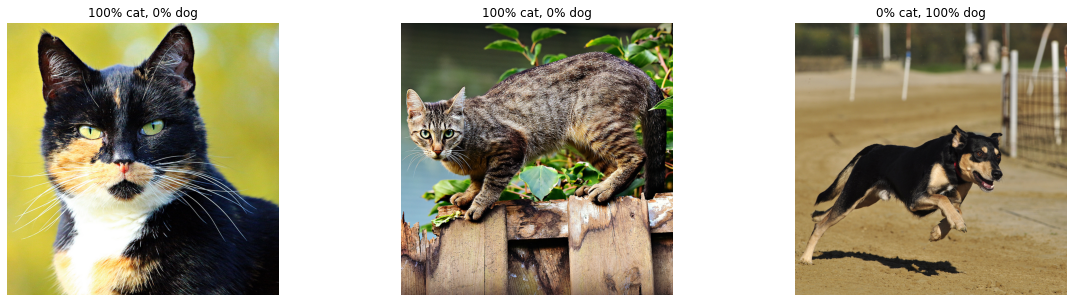

In [63]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% cat, {:.0f}% dog".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)